In [1]:
# get all paths for both the image and the label files of the training dataset
from glob import glob
base_path = '/mnt/marathon/train'

types = ('png', 'jpg') # the tuple of file types
imgs = []
for t in types:
    imgs.extend(glob(base_path + '/images/*.{}'.format(t)))

# jsons = glob(base_path + '/*.json')

# assert len(imgs) == len(jsons),"dataset issue: # of images = {} , and # of xml files = {}".format(len(imgs),len(jsons))

In [15]:
import json

with open('/mnt/marathon/train/train.json') as json_file:
        data = json.load(json_file)
        for annot in data['annotations']:
            if annot['image_id'] in imgs[0]:
                print(annot['bbox'])
                
            

[676.0, 767.0, 172.0, 313.0]
[860.0, 511.0, 255.0, 569.0]
[1160.0, 472.0, 274.0, 608.0]


In [5]:
print(imgs[0])

/mnt/marathon/train/images/nvr1_20181206_cam2_173000-026.jpg


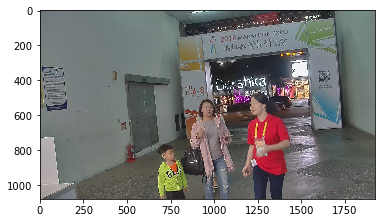

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(imgs[0])
plt.imshow(img)

In [ ]:
# # dictionary of classes for YOLOv3 training
# classes = {}
# with open('../data/custom/classes.names','r') as f:
#     for cnt, line in enumerate(f):
# #         print(line)
#         classes[line.strip()] = cnt
# # classes['4710105030326']

In [ ]:
# util function for corresponding the image with the label by
# getting the path of the label xml file according to the path of the image file

import os

def get_xml_from_image(img_path):

    p,f = os.path.split(img_path)
    name,ext = f.split('.')
    return os.path.join(p, name + '.xml')

In [ ]:
# After the Preparation
# Do the actual work of renaming, converting, moving to the correct folders the image and label files

import os
import shutil
import re
from tqdm import tqdm
img_dest_path = '../data/custom/images'
label_dest_path = '../data/custom/labels'

for img in tqdm(imgs):
    components = img.split('/')
    count = len(components)
    new_img_name = components[-4] + '_' + components[-3] + '_' + components[-2] + '_' + components[-1]
    new_label_name = components[-4] + '_' + components[-3] + '_' + components[-2] + '_' + components[-1].split('.')[0] + '.txt'


    label_idx = classes[components[-4]]
    
    shutil.copyfile(img,os.path.join(img_dest_path,new_img_name))

    with open(os.path.join(label_dest_path,new_label_name), "w+") as text_file:
        xml = get_xml_from_image(img)
        with open(xml, 'r') as f:
            text = f.read()
#         print("text= ", text)
        p_name = re.compile("<name>\s*(.*)\s*</name>")
        result = p_name.search(text)
        name = result.group(1)

        p_xmin = re.compile("<xmin>\s*(.*)\s*</xmin>")
        result = p_xmin.search(text)
        xmin = result.group(1)

        p_xmax = re.compile("<xmax>\s*(.*)\s*</xmax>")
        result = p_xmax.search(text)
        xmax = result.group(1)

        p_ymin = re.compile("<ymin>\s*(.*)\s*</ymin>")
        result = p_ymin.search(text)
        ymin = result.group(1)

        p_ymax = re.compile("<ymax>\s*(.*)\s*</ymax>")
        result = p_ymax.search(text)
        ymax = result.group(1)

        p_width = re.compile("<width>\s*(.*)\s*</width>")
        result = p_width.search(text)
        img_width = result.group(1)

        p_height = re.compile("<height>\s*(.*)\s*</height>")
        result = p_height.search(text)
        img_height = result.group(1)

        bottom = float(ymax) / float(img_height)
        left = float(xmin) / float(img_width)
        width = abs(float(xmax) - float(xmin)) / float(img_width)
        height = abs(float(ymax) - float(ymin)) / float(img_height)
        
        out_line = '{} {:.9f} {:.9f} {:.9f} {:.9f}'.format(label_idx, left + (width / 2), bottom - (height / 2), width, height)
#         print(out_line)
        text_file.write(out_line)

In [ ]:
import os

def get_txt_from_image(img_path):

    p,f = os.path.split(img_path)
    name,ext = f.split('.')
    b,t = os.path.split(p)
    return os.path.join(b, 'labels', name + '.txt')

In [ ]:
# split training and validation set
split_ratio = 0.01
SEED = 1256

# Get the list of all image files

from glob import glob

types = ('png', 'jpg') # the tuple of file types
all_images = []
for t in types:
    all_images.extend(glob('../data/custom/images/*'))
#shuffle images order
import random

# random.seed(SEED)
random.shuffle(all_images)
# Get the list of all label files, aranged by the order that correponds to that of the list of all images  
all_labels = list(map(get_txt_from_image, all_images))

In [ ]:
# idx = 11
# all_images[idx],all_labels[idx]

In [ ]:
# write the train.txt file that defines the training dataset
number_of_train_data = int(len(all_images)*(1 - split_ratio))
print("number of train data: ", number_of_train_data)

with open('../data/custom/train.txt','w+') as f:
    for i in range(number_of_train_data):
        image_str = all_images[i][3:] + '\n'
#         print(image_str)
        f.write(image_str)

# write the valid.txt file that defines the validation dataset

number_of_valid_data = len(all_images) - number_of_train_data
print("number of validation data: ", number_of_valid_data)

with open('../data/custom/valid.txt','w+') as f:
    for i in range(number_of_valid_data):
        image_str = all_images[number_of_train_data + i][3:] + '\n'
#         print(image_str)
        f.write(image_str)